Link to paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7948653/
Link to GitHub: https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/master/StockPricePrediction.py

**LOAD IN preprocessing.py and INDEX.csv INTO RUNTIME FOR CODE TO RUN**

In [24]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
import yahoodata as yd # File added as a function to parse our index data

In [25]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [26]:
# IMPORTING DATASET (Skipped)
# XLV: Health Care Select Sector SPDR Fund

dataset = yd.yahooData("XLV")
dataset


,High,Low,Open,Close
Date,,,,
2018-01-02,83.650002,82.870003,82.989998,83.610001
2018-01-03,84.470001,83.360001,83.599998,84.410004
2018-01-04,84.839996,84.320000,84.680000,84.529999
2018-01-05,85.330002,84.639999,84.800003,85.250000
2018-01-08,85.260002,84.510002,85.150002,84.940002
...,...,...,...,...
2021-11-11,133.610001,132.830002,133.520004,133.149994
2021-11-12,134.119995,133.070007,134.000000,133.809998
2021-11-15,134.190002,132.850006,134.119995,132.979996


In [27]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [28]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

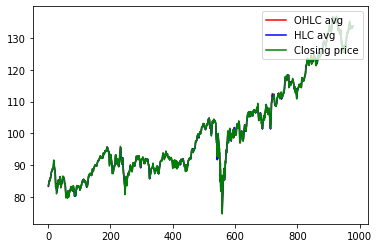

In [29]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()


In [30]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


In [31]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [32]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = preprocessing.new_dataset(train_OHLC, 1)
testX, testY = preprocessing.new_dataset(test_OHLC, 1)

In [33]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [34]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [35]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
731/731 - 5s - loss: 0.0082 - 5s/epoch - 7ms/step
Epoch 2/5
731/731 - 1s - loss: 3.8355e-04 - 1s/epoch - 2ms/step
Epoch 3/5
731/731 - 1s - loss: 3.6209e-04 - 1s/epoch - 2ms/step
Epoch 4/5
731/731 - 1s - loss: 3.7152e-04 - 1s/epoch - 2ms/step
Epoch 5/5
731/731 - 1s - loss: 3.5258e-04 - 1s/epoch - 2ms/step


In [36]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [37]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [38]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.23


In [39]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))


Test RMSE: 4.07


In [40]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [41]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [42]:
# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

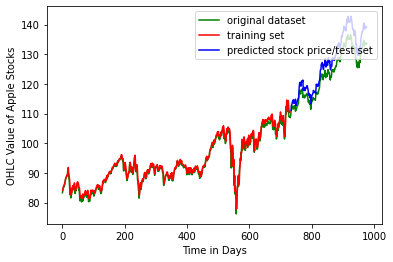

In [43]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()


In [44]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
# print np.append(last_val, next_val)


In [45]:
"Last Day Value:", last_val.item()

('Last Day Value:', 139.1892852783203)

In [46]:
"Next Day Value:", (last_val*next_val).item()

('Next Day Value:', 153.4960174560547)